In [32]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import  DataLoader, random_split
from torchvision import transforms, datasets, models
from os import listdir
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import time
import csv
import os
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA = {
    'train':'drive/My Drive/KAGGLE/Dog_Breed_Identification/data/train',
    'test':'drive/My Drive/KAGGLE/Dog_Breed_Identification/data/test',
    'labels':'drive/My Drive/KAGGLE/Dog_Breed_Identification/data/labels.csv', # labels for train images
    'sample':'drive/My Drive/KAGGLE/Dog_Breed_Identification/data/sample_submission.csv'
}

In [2]:
# print('Number of train images: ', len(files)) -> 10222
labels = pd.read_csv(DATA['labels'])
print('Number of labels: ', len(labels))
print('Number of test images: ', len(listdir(DATA['test'])))
sample = pd.read_csv(DATA['sample'])
print('Number of sample submission: ', len(sample))
print('Number of classes in labels: ', len(set(labels['breed'])))

Number of labels:  10222
Number of test images:  10357
Number of sample submission:  10357
Number of classes in labels:  120


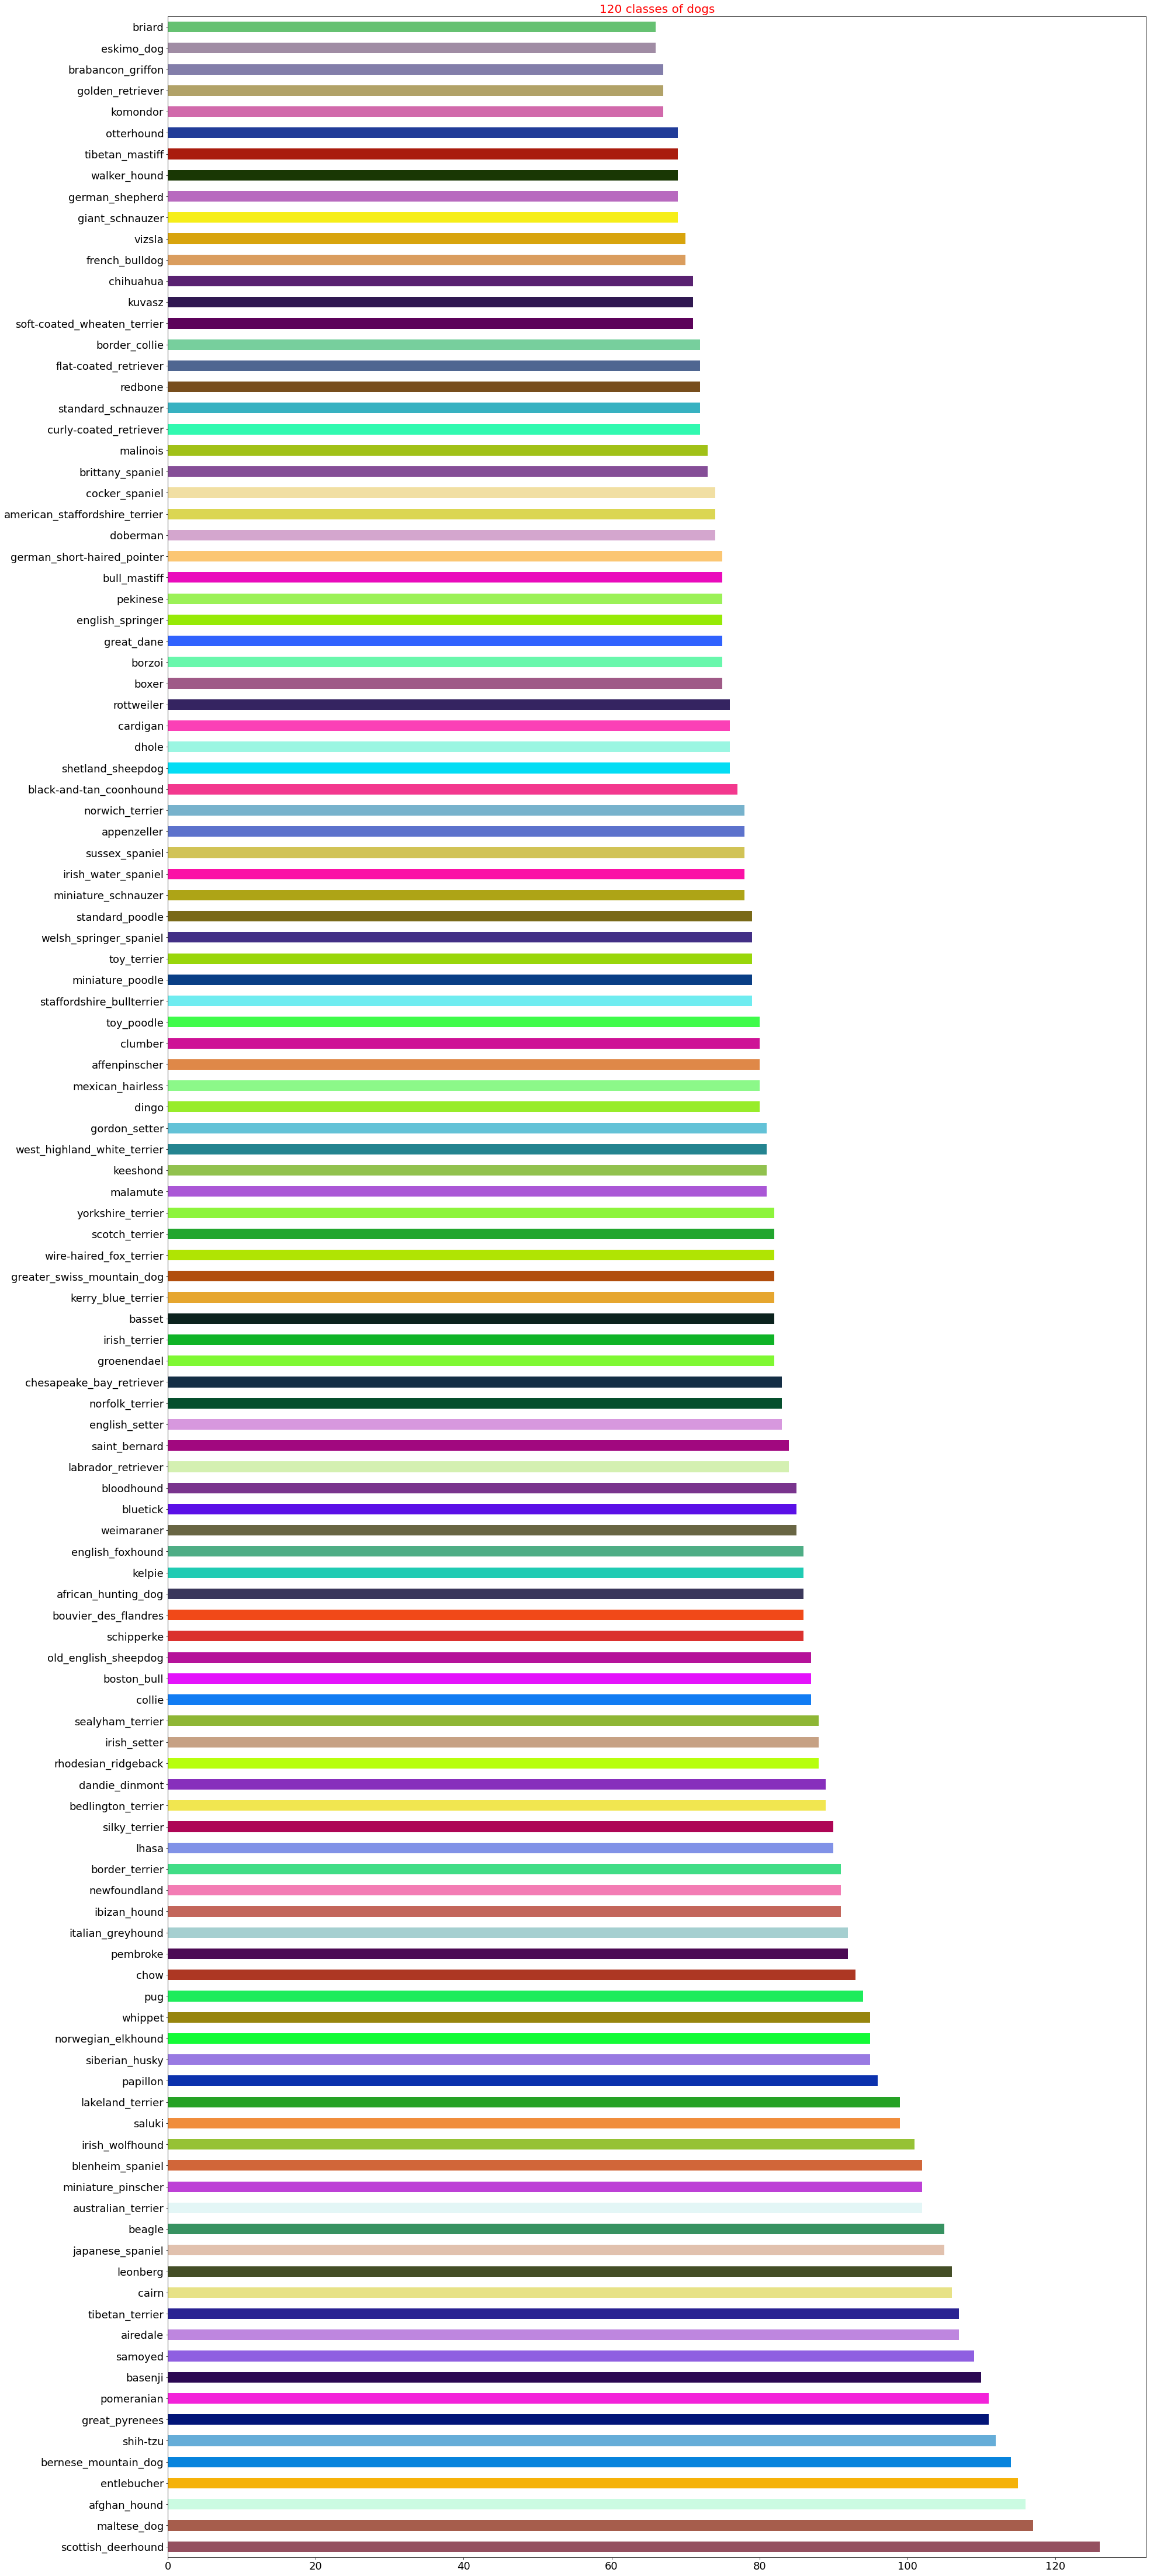

In [3]:
bar = labels['breed'].value_counts(ascending = False).plot.barh(figsize = (30,80), color = (np.random.rand(3,) for i in range(len(set(labels['breed'])))), align= 'center')
bar.tick_params(labelsize = 18)
plt.title('120 classes of dogs', fontsize = 20, color = 'red')
plt.show()

In [4]:
labels['breed'].value_counts(ascending = False)

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
golden_retriever         67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [5]:
# Make 120 folders contain images of each class, you just need to run this function once and it will change whole 'train' directory
def make_group_labels_images(): 
    filelist = []
    with open(DATA['labels']) as file:
        line = csv.reader(file)
        for row in line:
            filelist.append(row)

    for name,label in filelist[1:]:
        path = os.path.join(DATA['train'],name+".jpg")
        out_path = os.path.join(DATA['train'],label,name+".jpg")
        if not os.path.isdir(os.path.join(DATA['train'],label)):
            os.mkdir(os.path.join(DATA['train'],label))
        os.rename(path,out_path)

# make_group_labels_images()

In [6]:
labels_names = labels["breed"].unique()
labels_sorted = labels_names.sort()

labels_dict = dict(zip(range(len(labels_names)), labels_names))
len(labels_dict)

120

In [7]:
def display_images(data, labels):
    classes = len(labels_dict) # 120
    num_imgs = 20
    columns = 5 # columns * rows = num_imgs
    rows = 4

    rand = np.random.randint(0, classes, num_imgs)
    fig = plt.figure(figsize = (20,16))

    for i, lab in enumerate(rand):
        label =  labels_dict[lab]
        path = os.path.join(data, label)

        imgs_list = os.listdir(path)

        rand_imgs = np.random.randint(0, len(imgs_list))

        imgs = imgs_list[rand_imgs]

        fig.add_subplot(rows, columns, i + 1)
        images = Image.open(os.path.join(path, imgs))

        plt.axis('off')
        plt.title(label,fontsize = 20)
        plt.imshow(images)
        
    plt.tight_layout()
    plt.show()

display_images(DATA['train'], labels)
    






Output hidden; open in https://colab.research.google.com to view.

In [8]:
IMG_SIZE = 224
lengths = [int(10222*0.8), 10222 - int(10222*0.8)]
print(lengths[0]+lengths[1])

10222


# DATA AUGMENTATION - TRANSFORM

In [22]:
normalize = transforms.Normalize(
    mean = (0.4914, 0.4822, 0.4465),
    std = (0.2023, 0.1994, 0.2010)
)


transforms_train = transforms.Compose([
                                       transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                       transforms.CenterCrop((IMG_SIZE, IMG_SIZE)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.ToTensor(),
                                       normalize
])

transforms_test = transforms.Compose([
                                       transforms.Resize((256,256)),
                                       transforms.CenterCrop((IMG_SIZE, IMG_SIZE)),
                                       transforms.ToTensor(),
                                       normalize
])

In [10]:
BATCH_SIZE = 64

train_data = datasets.ImageFolder(DATA['train'], transform = transforms_train)
train_data, val_data = random_split(train_data, lengths) # split data into train and valid

# Feed to Dataloader
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers= 4)
val_loader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = False, num_workers= 4)


In [11]:
# Use resnet50 as pretrained model
resnet = models.resnet50(pretrained = True)
resnet = resnet.to(device)

for params in resnet.parameters():
    params.requires_grad = False

in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features = in_features, out_features = len(labels_dict)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.fc.parameters(),lr = 1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

In [12]:
dataloader = {'train': train_loader , 'val': val_loader}

print(len(dataloader['train'].dataset))
print(len(dataloader['val'].dataset))

8177
2045


In [13]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:
EPOCHS = 30
def train_model(model, dataloader, optimizer,scheduler, criterion, num_epochs = EPOCHS):
    best_acc = 0
    dataloader_size = {'train': len(dataloader['train'].dataset),
                       'val': len(dataloader['val'].dataset)}
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

    for epoch in range(num_epochs):
        start_time = time.time()

        for mode in ['train','val']:
            if mode == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0
            running_acc = 0
            for img, label in dataloader[mode]:
                optimizer.zero_grad()

                img = Variable(img).view(-1, 3, IMG_SIZE, IMG_SIZE).to(device)
                label = Variable(label).to(device)

                outputs = model(img)  
                preds = torch.max(outputs.data, 1)[1]
                loss = criterion(outputs, label)

                if mode == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_acc += torch.sum(preds == label.data)
            
            if mode == 'train':
                train_epoch_loss = running_loss /dataloader_size[mode]
                train_loss_list.append(train_epoch_loss)

                train_epoch_acc = float(running_acc) / dataloader_size[mode]
                train_acc_list.append(train_epoch_acc)
            
            else:
                val_epoch_loss = running_loss /dataloader_size[mode]
                val_loss_list.append(val_epoch_loss)

                val_epoch_acc = float(running_acc) / dataloader_size[mode]
                val_acc_list.append(val_epoch_acc)

            if mode == 'val' and val_epoch_acc > best_acc:
                best_acc = val_epoch_acc
                torch.save(model.state_dict(),'model/model1.pt')

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: [{epoch + 1: 02}/{num_epochs}] | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\t\t Train Loss: {train_epoch_loss :.4f} | Train Acc: {train_epoch_acc: .4f}')
        print(f'\t\t Val Loss: {val_epoch_loss :.4f} | Val Acc: {val_epoch_acc: .4f}')

    model.load_state_dict(torch.load('model/model1.pt'))        
    return model, train_loss_list, val_loss_list, train_acc_list, val_acc_list 


In [15]:
start_time = time.time()

model, train_loss_list, val_loss_list, train_acc_list, val_acc_list= train_model(resnet,dataloader,optimizer,scheduler,criterion,num_epochs=EPOCHS)

end_time = time.time()
mins, secs = epoch_time(start_time, end_time)
print(f'Total traning time: {mins}m {secs}s')

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: [ 1/30] | Epoch Time: 1m 7s
		 Train Loss: 0.0668 | Train Acc:  0.2034
		 Val Loss: 0.0578 | Val Acc:  0.4562
Epoch: [ 2/30] | Epoch Time: 1m 7s
		 Train Loss: 0.0509 | Train Acc:  0.5685
		 Val Loss: 0.0442 | Val Acc:  0.6269
Epoch: [ 3/30] | Epoch Time: 1m 8s
		 Train Loss: 0.0392 | Train Acc:  0.6857
		 Val Loss: 0.0346 | Val Acc:  0.7071
Epoch: [ 4/30] | Epoch Time: 1m 8s
		 Train Loss: 0.0311 | Train Acc:  0.7493
		 Val Loss: 0.0281 | Val Acc:  0.7413
Epoch: [ 5/30] | Epoch Time: 1m 8s
		 Train Loss: 0.0257 | Train Acc:  0.7712
		 Val Loss: 0.0236 | Val Acc:  0.7594
Epoch: [ 6/30] | Epoch Time: 1m 8s
		 Train Loss: 0.0218 | Train Acc:  0.7977
		 Val Loss: 0.0210 | Val Acc:  0.7687
Epoch: [ 7/30] | Epoch Time: 1m 8s
		 Train Loss: 0.0200 | Train Acc:  0.8152
		 Val Loss: 0.0208 | Val Acc:  0.7711
Epoch: [ 8/30] | Epoch Time: 1m 8s
		 Train Loss: 0.0197 | Train Acc:  0.8152
		 Val Loss: 0.0204 | Val Acc:  0.7736
Epoch: [ 9/30] | Epoch Time: 1m 8s
		 Train Loss: 0.0194 | Train

In [20]:
def plot_weight(train_loss_list,val_loss_list,train_acc_list,val_acc_list, epoch):
    fig = plt.figure(figsize = (20,10))
    # fig 1 - Loss
    fig.add_subplot(1,2,1)
    plt.plot(range(epoch),train_loss_list,label = 'Train Loss')
    plt.plot(range(epoch),val_loss_list,  label = 'Val Loss', color = 'red')
    plt.legend()
    plt.title('Lossses in model')

    #fig 2 - Acc
    fig.add_subplot(1,2,2)
    plt.plot(range(epoch),train_acc_list,label = 'Train Acc')
    plt.plot(range(epoch),val_acc_list,label = 'Val Acc', color = 'green')
    plt.legend()
    plt.title('Accs in model')

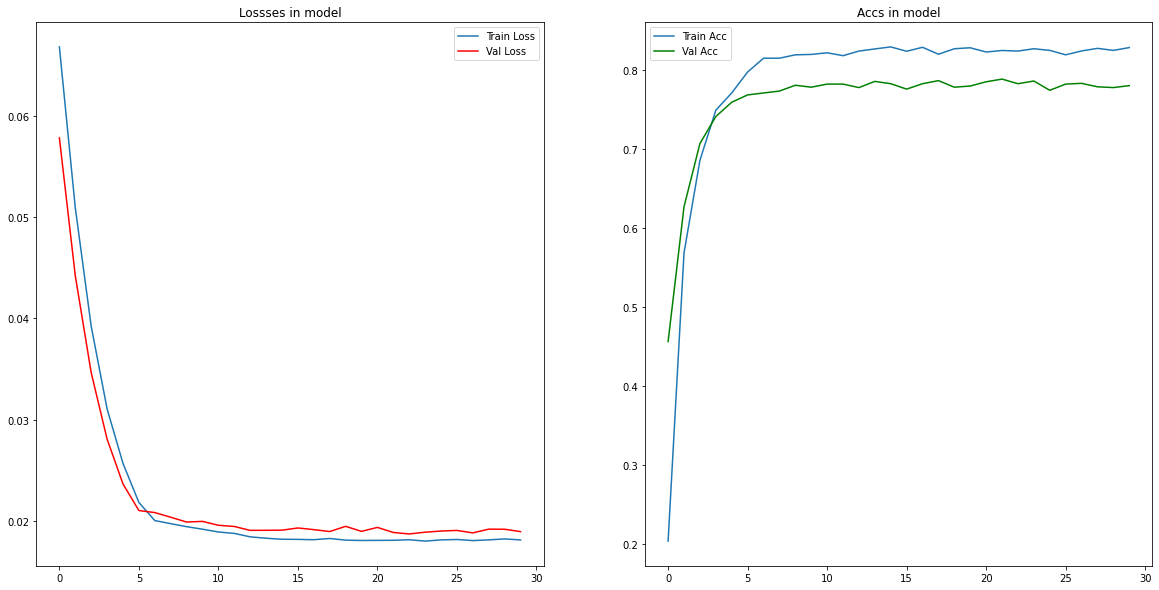

In [21]:
# Analyze loss, acc
plot_weight(train_loss_list,val_loss_list,train_acc_list,val_acc_list, EPOCHS)

In [30]:
def predict_images(model, images):
    model.eval()

    with torch.no_grad():
        test = Variable(images).view(-1,3,IMG_SIZE,IMG_SIZE)
        test = test.to(device)

        outputs= model(test)
        preds = F.softmax(outputs.data,dim = 1)
    
    return preds.cpu().numpy()[0]

In [31]:
def visualize_test_images(model,data, num_img = 20):
    columns = 5
    rows = 4
    path = listdir(data)
    print(path)

    rand = np.random.randint(len(path))
    fig = plt.figure(figsize = (20,16))
    for i, lab in enumerate(path[rand: rand+ num_img]):
        img = Image.open(os.path.join(data, path[i]))
        img_transform = transforms_test(img)

        outputs = predict_images(model,img_transform)
        outputs = np.argmax(outputs)
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(labels_dict[outputs])
    plt.tight_layout()
    plt.show()

visualize_test_images(model,DATA['test'],num_img = 20)

Output hidden; open in https://colab.research.google.com to view.

In [35]:
list(labels_dict.values())

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [37]:
def to_csv(model):
    lines = []
    path = os.listdir(DATA['test'])
    for i, lab in tqdm(enumerate(path[:])):
        img = Image.open(os.path.join(DATA['test'], lab))
        img_transform = transforms_test(img)
        outputs = list(predict_images(model, img_transform))
        lines.append([lab[:-4], outputs])
    
    with open('submission.csv','w',newline = '') as file:
        writer = csv.writer(file)
        writer.writerow(['id'] + list(labels_dict.values()))
        for i in lines:
            writer.writerow([i[0]] + [f'{j: .20f}' for j in i[1]])

to_csv(model)

10357it [02:37, 65.83it/s]
